In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
path= "combf"
path= "small"
path_csv="bm18_data3_0pass1_freq0_big1_pa100_t12_eq1_lc1.csv"

In [3]:
import os
import geopandas
import pandas as pd
import folium
import base64

In [4]:
from shapely.geometry import Polygon

def create_polygon(box):
    """create box polygon for clipping the geopands df
    """
    (max_lat, min_lon), (min_lat, max_lon) = box
    return Polygon([(min_lon, max_lat), 
                    (min_lon, min_lat), 
                    (max_lon, min_lat), 
                    (max_lon, max_lat), 
                    (min_lon, max_lat)])

In [5]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

class MplColorHelper:

  def __init__(self, cmap_name, start_val, stop_val):
    self.cmap_name = cmap_name
    self.cmap = plt.get_cmap(cmap_name)
    self.norm = matplotlib.colors.Normalize(vmin=start_val, vmax=stop_val)
    self.scalarMap = cm.ScalarMappable(norm=self.norm, cmap=self.cmap)

  def get_rgb(self, val):
    return self.scalarMap.to_rgba(val)

In [6]:
files = os.listdir(path)

In [7]:
rdf = pd.read_csv(path_csv, header=None)
rdf = rdf[(rdf[0]==4)&(rdf[4]>0)]
rdf

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,4,-10,13,1,0.344650,-0.092244,7.4709,6,80,7409.0,...,58,29,0,0.0,0,0,0,0,0,199.84
5,4,-10,18,6,0.139500,-1.581500,17.5270,4,80,124890.0,...,165,7,0,0.0,0,0,0,0,0,199.84
6,4,-10,19,7,0.533910,0.378550,27.5120,5,80,56054.0,...,138,14,0,0.0,0,0,0,0,0,273.64
7,4,-10,20,8,0.098575,-0.502380,3.3268,6,80,145600.0,...,126,7,0,0.0,0,0,0,0,0,347.44
8,4,-10,21,9,0.000100,-1.999700,32.6280,4,80,630960.0,...,148,13,0,0.0,0,0,0,0,0,327.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4014,4,9,-80,4015,0.153370,-0.693250,72.0900,5,80,235740.0,...,126,44,0,0.0,0,0,0,0,0,222.59
4015,4,9,-81,4016,0.327450,0.159320,42.2360,11,80,3483100.0,...,189,51,210,39.0,274,182,236,207,35,206.59
4016,4,9,-82,4017,0.893420,0.680260,10.1890,4,80,4401500.0,...,215,47,199,14.0,267,171,229,198,36,198.64
4017,4,9,-83,4018,0.744950,0.642930,41.3600,8,80,3312600.0,...,197,68,206,8.0,298,167,241,203,53,203.36


In [ ]:
15:recovery time 
16:recovery time 

In [8]:
lat =[]
lon =[]
R2 =[]
geometry =[]
file =[]
RT = []
for index, row in rdf.iterrows():
    la, lo, r2, rt = int(row[1]), int(row[2]), row[4], row[15]
    if rt>100:
        rt=100
    f = [files.index(l) for l in files if l.startswith(f"{la}_{lo}")]
    lat.append(la)
    lon.append(lo)
    R2.append(r2)
    RT.append(rt)
    geometry.append(create_polygon(((la,lo),(la-1, lo-1))))
    file.append(None if len(f)==0 else files[f[0]])

In [10]:
d = {'lat': lat, 'lon': lon, "r2":R2, "recovery time":RT, "file":file, "geometry": geometry}
gdf = geopandas.GeoDataFrame(d, crs='epsg:4326')

In [13]:
gdf["file"].unique()

array(['-10_13_1_121221213111.png', '-10_18_6_121221213111.png',
       '-10_19_7_121221213111.png', ..., '9_-82_496_121221213111.png',
       '9_-83_497_121221213111.png', '9_-84_498_121221213111.png'],
      dtype=object)

In [38]:
# gdf.explore(column="r2", cmap="copper",style_kwds={"weight":0.1})

In [16]:
s=0
for i, r in gdf.iterrows():
    if r["file"] is None:
        s+=1
s

463

In [ ]:
# color_map = MplColorHelper("autumn_r",0,1)
# m = folium.Map()
m = gdf.explore(name="r2", column="r2", cmap="Reds",style_kwds={"weight":0.5})
gdf.explore(name="recovery time", column="recovery time", cmap="YlGn",style_kwds={"weight":0.5}, m=m)

fg = folium.FeatureGroup(name="plots", show=True)

# create a geojson layer for each feature
for i, r in gdf.iterrows():
    # if i>100:
    #     break
    # geodataframe of row
    gdf_ = geopandas.GeoDataFrame(r.to_frame().T, crs=gdf.crs)
    
    scr = ""
    if r["file"] is not None:
        f_path = os.path.join(path, r["file"])
        encoded = base64.b64encode(open(f_path, 'rb').read())
        scr = "data:image/png;base64," + encoded.decode("utf-8")
    # URI encoded image of plotly figure
    img_ = f'<img width="450" height="450" src="{scr}"/>'

        
    choro_ = folium.GeoJson(
        gdf_.__geo_interface__,
        name=r["file"],
        style_function=lambda x: {"fillOpacity":0,
                                  "opacity":0},
        tooltip=folium.GeoJsonTooltip(gdf_.drop(columns=["file", "geometry"]).columns.tolist()),
    )
    # this is the real work around, add to layer which is a choro
    folium.Popup(img_).add_to(choro_)
    choro_.add_to(fg)

fg.add_to(m)
folium.LayerControl().add_to(m)
m.save("map.html")
m

In [41]:
m.save("map.html")

In [110]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

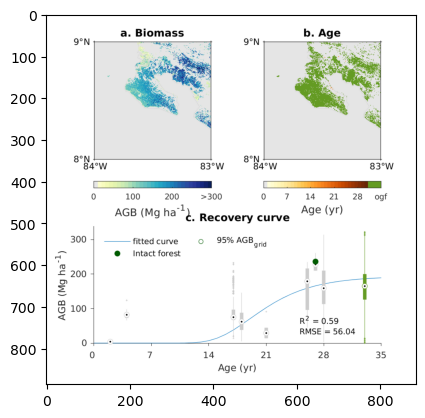

In [111]:
img = mpimg.imread(f_path)
plt.imshow(img)

In [44]:
color

(0.029065737105639713, 0.018381176470588234, 0.011705882352941177, 1.0)

In [45]:
COL = MplColorHelper('autumn_r', 0, 1)

In [27]:
from PIL import Image

In [28]:
for f in files:
    image = Image.open(os.path.join(path, f))
    new_image = image.resize((500, 500))
    new_image.save(os.path.join("small", f))